## Data Import

In [22]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!pip install geopandas

In [23]:
import pandas as pd
import numpy as np
import joblib

import geopandas
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

import random
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [24]:
Data = pd.read_csv("/gdrive/MyDrive/2. Crime Analysis.csv")

In [25]:
print(Data.duplicated().sum())
Data.drop_duplicates(inplace=True)
assert Data.duplicated().sum() ==0

2323


In [26]:
Data

Dates                Category  ...           X          Y
0       2015-05-13 23:53:00                WARRANTS  ... -122.425892  37.774599
1       2015-05-13 23:53:00          OTHER OFFENSES  ... -122.425892  37.774599
2       2015-05-13 23:33:00          OTHER OFFENSES  ... -122.424363  37.800414
3       2015-05-13 23:30:00           LARCENY/THEFT  ... -122.426995  37.800873
4       2015-05-13 23:30:00           LARCENY/THEFT  ... -122.438738  37.771541
...                     ...                     ...  ...         ...        ...
878044  2003-01-06 00:15:00                 ROBBERY  ... -122.459033  37.714056
878045  2003-01-06 00:01:00           LARCENY/THEFT  ... -122.447364  37.731948
878046  2003-01-06 00:01:00           LARCENY/THEFT  ... -122.403390  37.780266
878047  2003-01-06 00:01:00               VANDALISM  ... -122.390531  37.780607
878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING  ... -122.394926  37.738212

[875726 rows x 9 columns]

# Data Understanding
Usually, whilst building models people spend around 80% of their time understanding the data. Take your time

##Dates


In [10]:
# Dates
Data['Dates_Converted']=pd.to_datetime(Data['Dates'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

year= Data['Dates_Converted'].dt.year
month= Data['Dates_Converted'].dt.month
day= Data['Dates_Converted'].dt.day
hour= Data['Dates_Converted'].dt.hour
dayofweek= Data['Dates_Converted'].dt.dayofweek #Mon 0 , Sun 6

Text(0.5, 1.0, 'Day of Week')

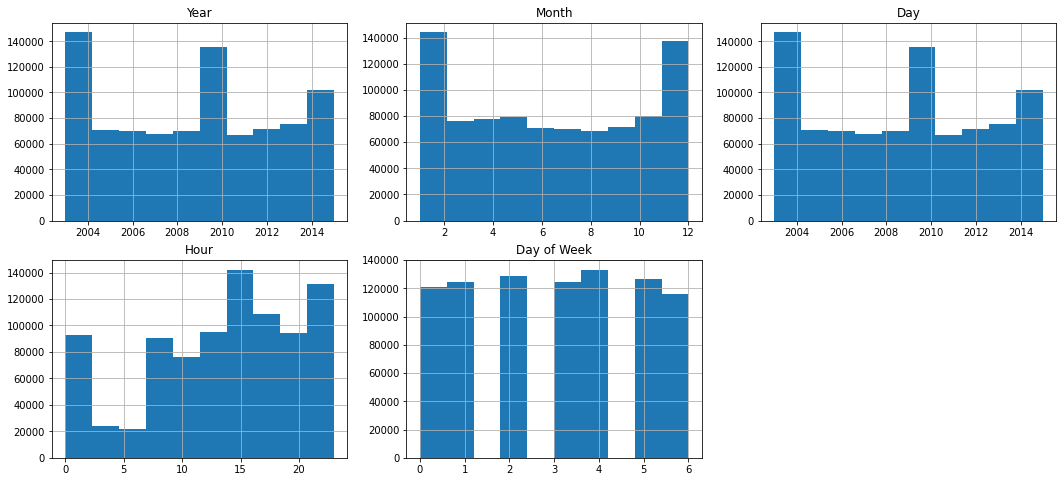

In [17]:
# Data plots

plt.figure(figsize=(18,8))

rows=2
cols=3

plt.subplot(rows,cols,1)
year.hist()
plt.title('Year')

plt.subplot(rows,cols,2)
month.hist()
plt.title('Month')

plt.subplot(rows,cols,3)
year.hist()
plt.title('Day')

plt.subplot(rows,cols,4)
hour.hist()
plt.title('Hour')

plt.subplot(rows,cols,5)
dayofweek.hist()
plt.title('Day of Week')

## X and Y location


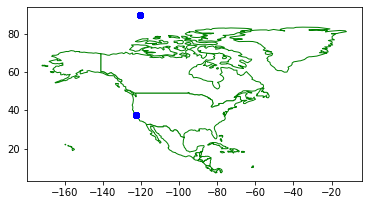

In [12]:
# X Y 
gdf = geopandas.GeoDataFrame(Data, geometry=geopandas.points_from_xy(Data.X, Data.Y))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='green')

gdf.plot(ax=ax, color='blue')

plt.show()

In [33]:
# 67 outliers
#-120.5	90.0

# Convert Outliers in nan
Data.loc[Data['Y']>80,['X','Y']] = np.nan

# Fill Outliers with median of values
Data['X'] = Data['X'].fillna(Data['X'].median())
Data['Y'] = Data['Y'].fillna(Data['Y'].median())

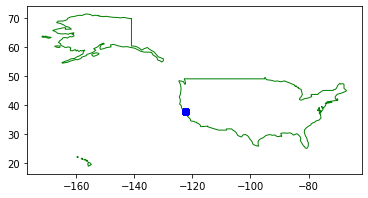

In [16]:
# Graph X_adj & Y_adj
gdf = geopandas.GeoDataFrame(Data, geometry=geopandas.points_from_xy(Data.X, Data.Y))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == "United States of America"].plot(color='white', edgecolor='green')

gdf.plot(ax=ax, color='blue')

plt.show()

Text(0.5, 1.0, 'Y_adj')

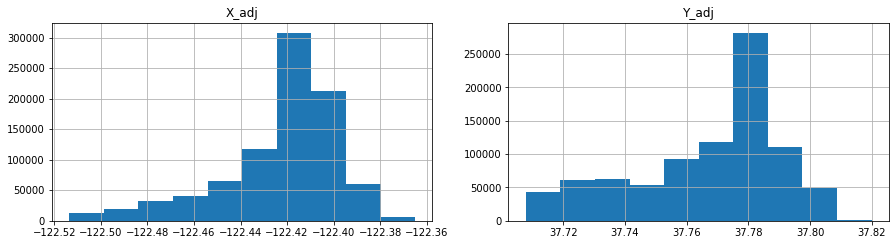

In [34]:
# Distribution X_adj & Y_adj
plt.figure(figsize=(15,8))

rows=2
cols=2

x_adj= Data.X
y_adj= Data.Y

plt.subplot(rows,cols,1)
x_adj.hist()
plt.title('X_adj')

plt.subplot(rows,cols,2)
y_adj.hist()
plt.title('Y_adj')

## Address

In [17]:
# Address
Data['Address'].value_counts()

800 Block of BRYANT ST          26245
800 Block of MARKET ST           6576
2000 Block of MISSION ST         5094
1000 Block of POTRERO AV         4046
900 Block of MARKET ST           3245
                                ...  
GRIJALVA DR / GARCES DR             1
ALAMEDA ST / RHODE ISLAND ST        1
BRENTWOOD AV / FERNWOOD DR          1
100 Block of COLTON ST              1
SONORA LN / TERRAVISTA AV           1
Name: Address, Length: 23228, dtype: int64

In [18]:
def preprocess_num(text):
  # Tokenise to alphabetic tokens
  tokeniser = RegexpTokenizer(r'[A-Za-z0-9]+')
  tokens = tokeniser.tokenize(text)
  
  # Lowercase and lemmatise 
  lemmatiser = WordNetLemmatizer()
  tokens = [lemmatiser.lemmatize(t.lower(), pos='n') for t in tokens]

  # Remove stopwords
  stop_words = stopwords.words('english')
  tokens = [t for t in tokens if t not in stop_words]
  return tokens

In [19]:
vectorizer_num = TfidfVectorizer(analyzer=preprocess_num, min_df=30)

## For testing
#inspect(vectorizer_num, Data['Address']) # 1346 feat

## Descript

In [20]:
def preprocess_text(text):
  # Tokenise to alphabetic tokens
  tokeniser = RegexpTokenizer(r'[A-Za-z]+')
  tokens = tokeniser.tokenize(text)
  
  # Lowercase and lemmatise
  lemmatiser = WordNetLemmatizer()
  tokens = [lemmatiser.lemmatize(t.lower(), pos='v') for t in tokens]

  # Remove stopwords
  stop_words = stopwords.words('english')
  tokens = [t for t in tokens if t not in stop_words]
  return tokens

In [21]:
# Description
Data['Descript'].value_counts()
vectorizer_txt = TfidfVectorizer(analyzer=preprocess_text, min_df=30)

## For testing
#inspect(vectorizer_text, Data['Descript']) #548

## Resolution


In [22]:
# Resolution 
Data['Resolution'].value_counts()

NONE                                      525122
ARREST, BOOKED                            206173
ARREST, CITED                              76832
LOCATED                                    16889
PSYCHOPATHIC CASE                          14529
UNFOUNDED                                   9577
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3969
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3710
JUVENILE CITED                              3322
PROSECUTED BY OUTSIDE AGENCY                2503
EXCEPTIONAL CLEARANCE                       1528
JUVENILE ADMONISHED                         1451
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

## District

In [23]:
# PdDistrict -- CATEGORICAL
Data['PdDistrict'].value_counts()

SOUTHERN      156528
MISSION       119723
NORTHERN      105105
BAYVIEW        89098
CENTRAL        85267
TENDERLOIN     81642
INGLESIDE      78722
TARAVAL        65400
PARK           49161
RICHMOND       45080
Name: PdDistrict, dtype: int64

## Category

In [24]:
# Category
Data['Category'].value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

# Dataset


In [25]:
Dataset = pd.DataFrame(data={'Year': year # Categorical
                            ,'Month': month # Categorical
                            ,'Day': day # Categorical
                            ,'Hour': hour # Categorical
                            ,'Dayofweek': dayofweek # Categorical
                            ,'X_adj':Data['X'] # Numeric
                            ,'Y_adj':Data['Y'] # Numeric
                            ,'PdDistrict': Data['PdDistrict'] # Categorical
                            ,'Resolution': Data['Resolution'] # vectorizer_txt
                            ,'Address': Data['Address'] # vectorizer_num
                            ,'Descript': Data['Descript'] # vectorizer_txt
                            ,'Category': Data['Category'] 
                             })

In [26]:
numeric_features = ['X_adj', 'Y_adj']
categorical_features = ['Year','Month','Day','Hour','Dayofweek','PdDistrict']
vect_num_features = 'Address'
vect_txt_features = ['Descript','Resolution']

In [162]:
# Train and Validation Datasets
x = Dataset.drop('Category', axis = 1)
lb= LabelEncoder()
y = lb.fit_transform(Dataset['Category'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=723)

In [28]:
# Data preprocessing according to variable type
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(), categorical_features),
        ("vectorizer_add", vectorizer_num, 'Address'),
        ("vectorizer_desc", vectorizer_txt, 'Descript'),
        ("vectorizer_res", vectorizer_txt, 'Resolution')
        ]
    )

# Apply the same preprocessing of train to test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Model
Model Tunned using Bayesian Optimization


**Algorithm Experiment Summary:**

Algorithm                  | Accuracy         | Balanced Accuracy
-------------------        |------------------|------------
LGBM - multiclass - V1     | 99.9%            | 95.5463%
LGBM - OVA - V1            | 01.1042%         | 12.7477%
LGBM - multiclass - opt1    | 99.9444%         | 99.6024%
**LGBM - multiclass - opt2**| **99.9429%**     | **99.6119%**
LGBM - multiclass - opt3    | 99.9448%         | 99.2498%

In [42]:
# Model Parameters


# TOP 3 Possible Options:

#LGBM - multiclass - opt1
#|   iter    |  target   |    est    |    lr     |    mds    |    nl     |
# 6        |  0.9969   |  420.3    |  0.9686   |  0.3134   |  78.77    |

#LGBM - multiclass - opt2
#|   iter    |  target   |    ff     |    lr     |    mds    |    nl     |
#|  3        |  0.9968   |  0.7587   |  0.5434   |  0.4192   |  78.28    |

#LGBM - multiclass - opt3
#|   iter    |  target   |    est    |    ff     |    lr     |    mb     |    md     |    mds    |    nl     |
#|  8        |  0.9964   |  152.0    |  0.6077   |  0.682    |  284.7    |  266.3    |  0.4916   |  34.68    |
  
model = LGBMClassifier(objective="multiclass", 
                       num_class=39,
                       max_delta_step = 0.4192,
                       learning_rate= 0.5434, 
                       num_leaves = int(round(78.28)),
                       feature_fraction = 0.7587,
                       )

In [43]:
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
acc_balanced = balanced_accuracy_score(y_test, y_pred)
print('Accuracy: %.6f' % acc)
print('Accuracy Balanced: %.6f' % acc_balanced)

Accuracy: 0.999429
Accuracy Balanced: 0.996119


In [ ]:
# save model
joblib.dump(model, '/tmp/CrimeClassifier.pkl') 

# load model
#gbm_pickle = joblib.load('/tmp/CrimeClassifier.pkl')

## Confusion Matrix

In [166]:
Data['Category'].value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

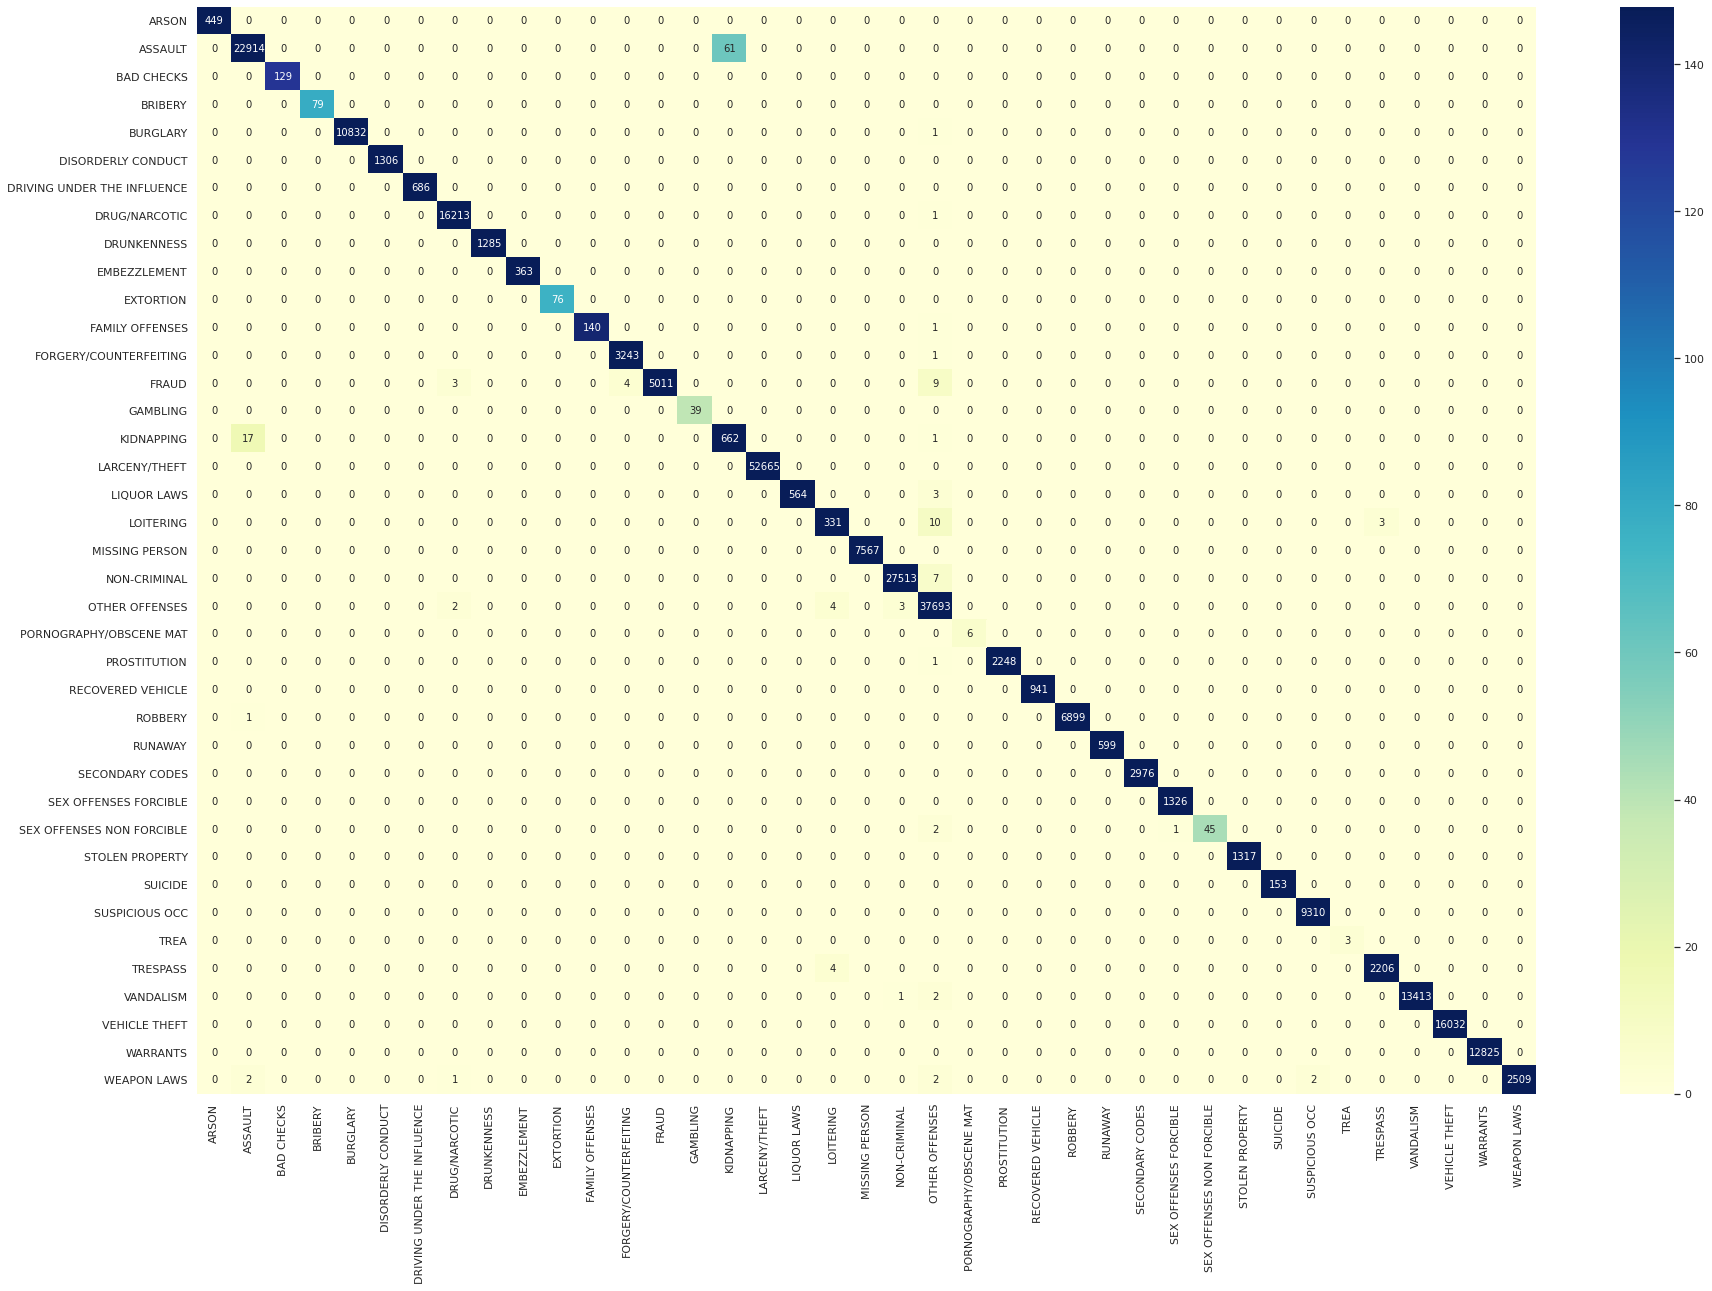

In [177]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=lb.classes_, index=lb.classes_)
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', robust=True)

## Feature Importances

In [143]:
#@title Feature Names
numerical_names = np.array(numeric_features) # Numerical Features Names
categorical_names = np.array(['year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008',
      'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
      'year_2015', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
      'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_1', 'day_2', 'day_3',
      'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
      'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
      'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
      'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'hour_0',
      'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
      'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
      'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
      'hour_23', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
      'District_BAYVIEW', 'District_CENTRAL', 'District_INGLESIDE', 'District_MISSION',
      'District_NORTHERN', 'District_PARK', 'District_RICHMOND', 'District_SOUTHERN',
      'District_TARAVAL', 'District_TENDERLOIN']) # Categorical Features Names
address_vocab = np.array(preprocessor.transformers_[2][1].get_feature_names()) # Address Names
description_vocab = np.array(preprocessor.transformers_[3][1].get_feature_names()) # Description Names
resolution_vocab = np.array(preprocessor.transformers_[4][1].get_feature_names()) # Resolution Names

numeric_i = 0
numeric_e = numeric_names.shape[0]

cat_i = numeric_e
cat_e = cat_i + categorical_names.shape[0]

add_i = cat_e
add_e = add_i + address_vocab.shape[0]

des_i = add_e
des_e = des_i + description_vocab.shape[0]

res_i = des_e
res_e = res_i + resolution_vocab.shape[0]

names_all = np.concatenate((numerical_names, categorical_names, address_vocab, description_vocab, resolution_vocab), axis=0)

No handles with labels found to put in legend.


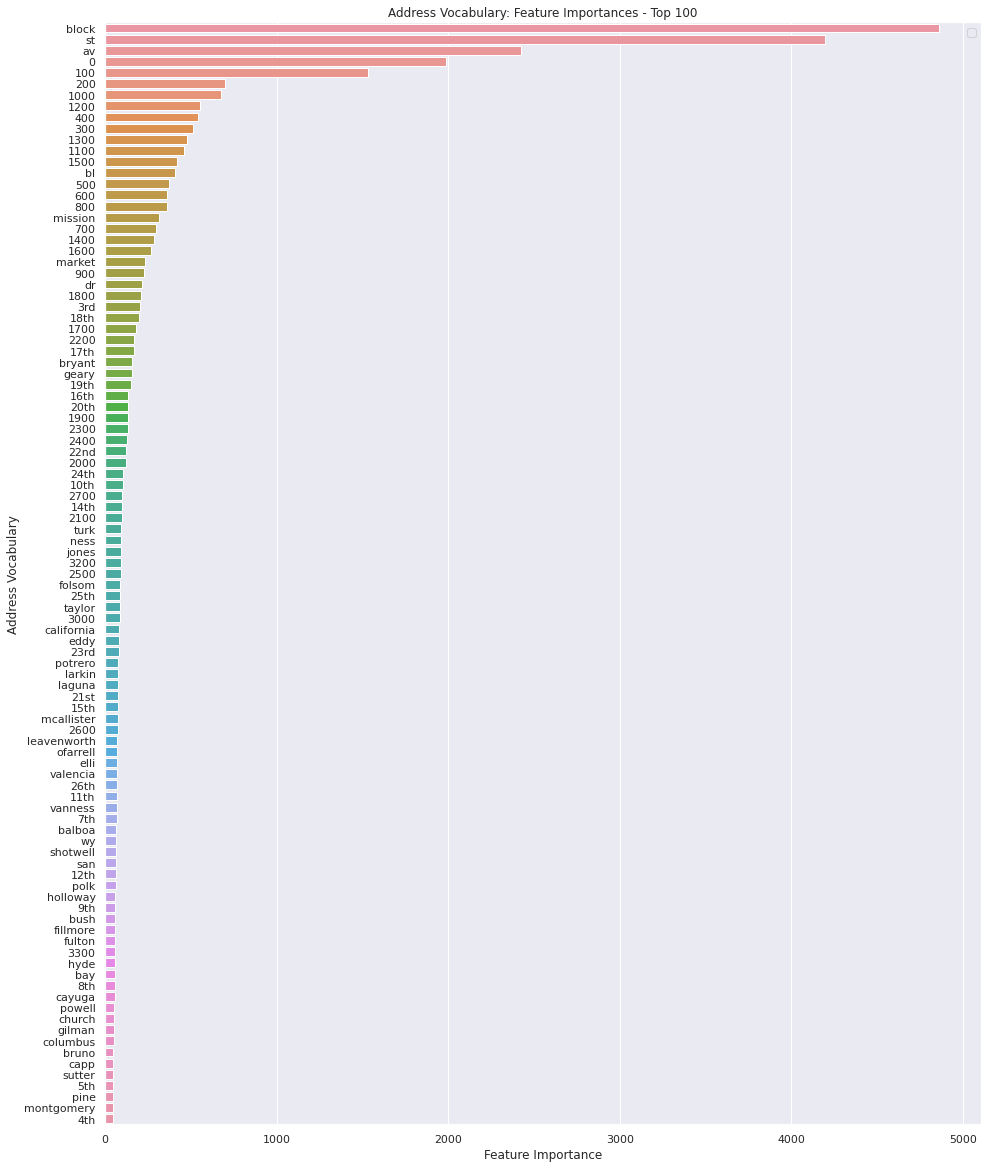

In [136]:
 import seaborn as sns

# 15.7,200.27
sns.set(rc={'figure.figsize':(15.7,20.27)})
names = address_vocab

fi = model.feature_importances_[add_i:add_e]
sorted_indices = np.argsort(fi)[::-1]
top100 = sorted_indices[:99]

fi = fi[top100]
names = names[top100]


sns.barplot(x=fi, y=names)
plt.xlabel('Feature Importance')
plt.ylabel('Address Vocabulary')
plt.title("Address Vocabulary: Feature Importances - Top 100")
plt.legend()
plt.show()

No handles with labels found to put in legend.


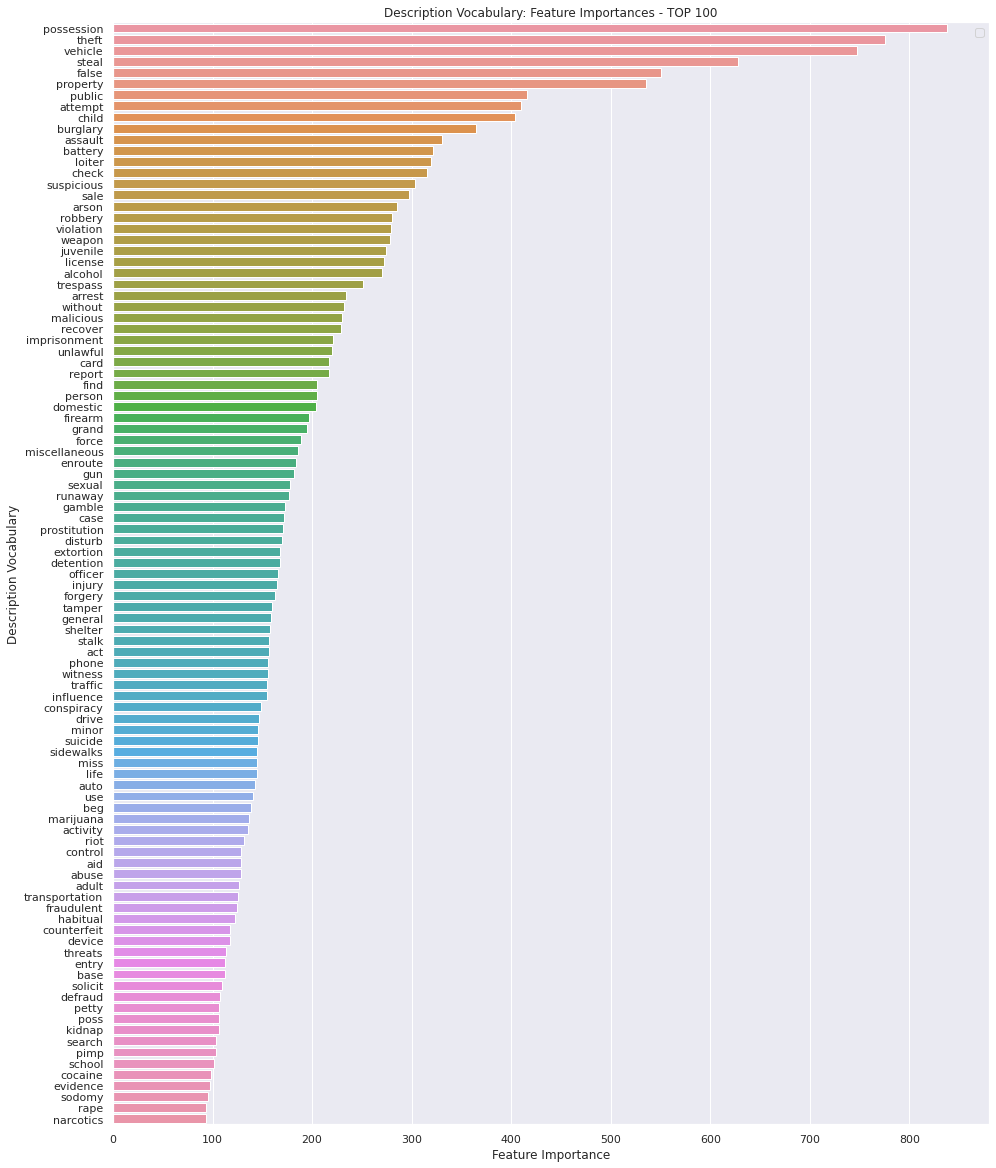

In [137]:
#Description Names

sns.set(rc={'figure.figsize':(15.7,20.27)})
names = description_vocab

fi = model.feature_importances_[des_i:des_e]
sorted_indices = np.argsort(fi)[::-1]
top100 = sorted_indices[:99]

fi = fi[top100]
names = names[top100]


sns.barplot(x=fi, y=names)
plt.xlabel('Feature Importance')
plt.ylabel('Description Vocabulary')
plt.title('Description Vocabulary: Feature Importances - TOP 100')
plt.legend()
plt.show()

No handles with labels found to put in legend.


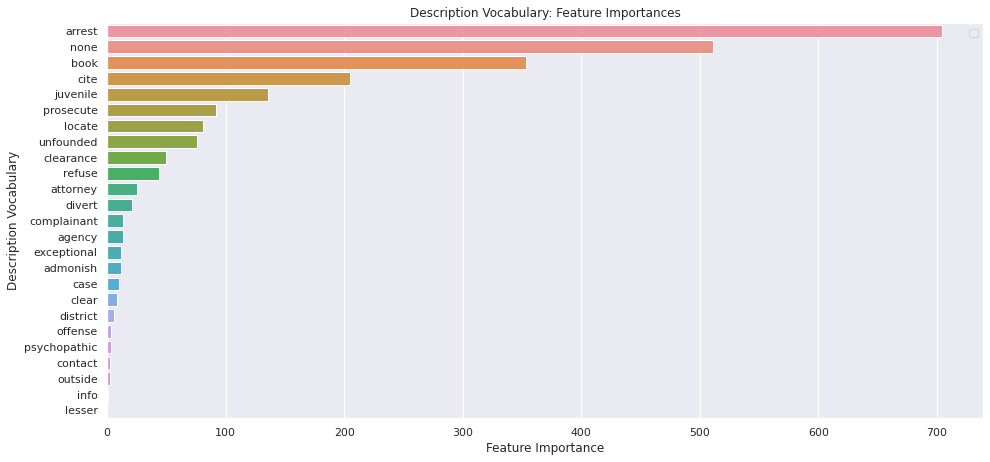

In [140]:
#Resolution Names

sns.set(rc={'figure.figsize':(15.7,7.27)})
names = resolution_vocab

fi = model.feature_importances_[res_i:res_e]
sorted_indices = np.argsort(fi)[::-1]
top100 = sorted_indices[:99]

fi = fi[sorted_indices]
names = names[sorted_indices]


sns.barplot(x=fi, y=names)
plt.xlabel('Feature Importance')
plt.ylabel('Description Vocabulary')
plt.title('Description Vocabulary: Feature Importances')
plt.legend()
plt.show()

No handles with labels found to put in legend.


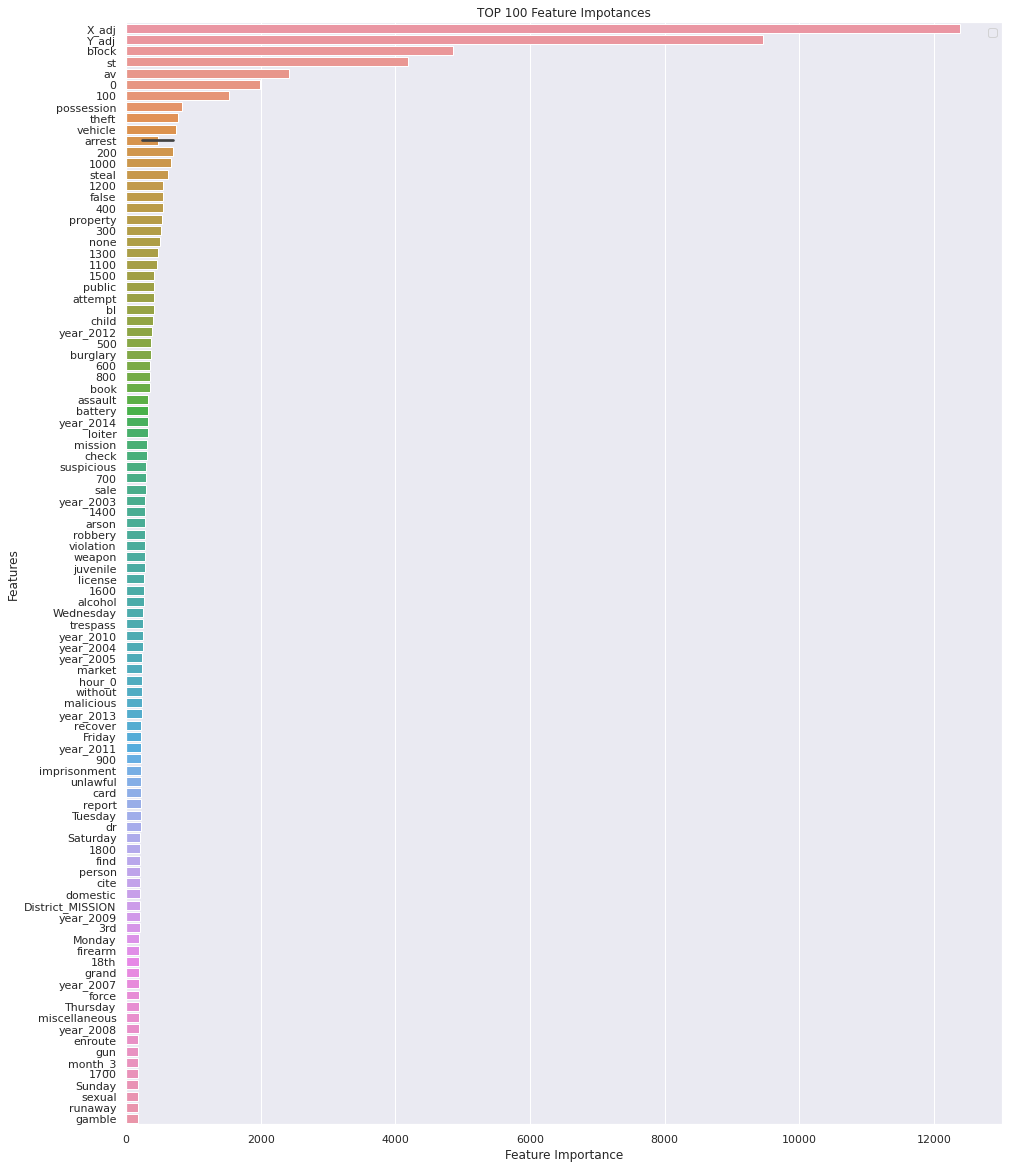

In [145]:
#All Features TOP 100

sns.set(rc={'figure.figsize':(15.7,20.27)})
names = names_all

fi = model.feature_importances_
sorted_indices = np.argsort(fi)[::-1]
top100 = sorted_indices[:99]

fi = fi[top100]
names = names[top100]


sns.barplot(x=fi, y=names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('TOP 100 Feature Impotances')
plt.legend()
plt.show()

# Hyperparameter Tunning

Bayesian Optimization to tune parameters

**Target=**  Balanced Accuracy

## **Results**

**First Optimization:** Target = Balanced Accuracy

|   iter    |  target   |    est    |    lr     |    mds    |    nl     |
------------|------------|----------|-----------|-----------|---------------
|  2        |  0.8016   |  158.7    |  0.1014   |  0.1863   |  54.84    |
|  3        |  0.9966   |  258.7    |  0.5434   |  0.4192   |  78.28    |
|  6        |  0.9969   |  420.3    |  0.9686   |  0.3134   |  78.77    |

**Second Optimization:** Target = Balanced Accuracy Fixed est =100

|   iter    |  target   |    ff     |    lr     |    mds    |    nl     |
------------|-----------|----------|-----------|-----------|------------------
|  1        |  0.02632  |  0.7668   |  0.7231   |  0.000114 |  51.86    |
|  2        |  0.5316   |  0.6587   |  0.1014   |  0.1863   |  54.84    |
|  3        |  0.9968   |  0.7587   |  0.5434   |  0.4192   |  78.28    |

**Third Optimization:** Target = Balanced Accuracy

|   iter    |  target   |    est    |    ff     |    lr     |    mb     |    md     |    mds    |    nl     |
------------|------------|------------|------------|------------|------------|------------|------------|-------------
|  2        |  0.9932   |  238.2    |  0.7587   |  0.5434   |  367.7    |  685.5    |  0.2045   |  91.59    |
|  4        |  0.9944   |  487.3    |  0.7254   |  0.6954   |  550.6    |  894.7    |  0.08504  |  33.69    |
|  8        |  0.9964   |  152.0    |  0.6077   |  0.682    |  284.7    |  266.3    |  0.4916   |  34.68    |

## Bayesian Parameter Optimization

In [34]:
def evaluate_algorithm( lr, md, est, ff, mb):
  model = LGBMClassifier(objective="multiclass", 
                       num_class=39,
                       max_delta_step = 0.4192,
                       learning_rate= lr, 
                       num_leaves = 78,
                        feature_fraction = ff,
                         max_depth = int(round(md)),
                       n_estimators= int(round(est)),
                       max_bin = int(round(mb)),
                       )
  # Fit model
  model.fit(X_train[:105000,:], y_train[:105000])
  
  # Predictions
  y_pred = model.predict(X_test[:45000])

  # Evaluate predictions
  acc_balanced = balanced_accuracy_score(y_test[:45000], y_pred)

  return acc_balanced

In [35]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import time
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounds for parameters
pbounds = {
           'lr': (0.01, 1),
           'ff': (0.6,1),
           'md':(1,1000),
           'est': (100,500),
           'mb':(200,600),
          }

optimizer = BayesianOptimization(
    f=evaluate_algorithm,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=100,)
time_took = time.time() - start_time

print(f"Total runtime:",  time_took)
print(optimizer.max)

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=b60fc0b5a7f4de48a481b2d1ec170d030cc647053002355ee5328559b581c5ab
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
|   iter    |  target   |    est    |    ff     |    lr     |    mb     |    md     |    mds    |    nl     |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.05206  |  266.8    |  0.8881   |  0.01011  |  320.9    |  147.6    |  0.09234  |  43.85    |
|  2        |  0.9932   |  238.2    |  0.7587   |  0.5434   |  367.7    |  685.5    |  0.2045   |  91.59    |
|  3        |  0.9631   |  111.0    |  0.8682   |  0.4231   |  423.5    |  141.2    |  0.1981   |  86.25    |
|  4        |  0.9944   |  487.3    |  0.7254   |  0.6954   |  550.6    |  894.7    |  0.08504  |  33.69    |
|  5       

KeyboardInterrupt: ignored

# Outliers Understanding

In [27]:
xy_outliers = Data.loc[Data['Y'] > 80]

In [28]:
xy_outliers

Dates               Category  ...      X     Y
660485  2005-12-30 17:00:00          LARCENY/THEFT  ... -120.5  90.0
660711  2005-12-30 00:34:00                ASSAULT  ... -120.5  90.0
660712  2005-12-30 00:34:00                ASSAULT  ... -120.5  90.0
661106  2005-12-29 00:07:00           NON-CRIMINAL  ... -120.5  90.0
666430  2005-11-30 11:25:00         OTHER OFFENSES  ... -120.5  90.0
...                     ...                    ...  ...    ...   ...
844995  2003-06-11 08:49:00         OTHER OFFENSES  ... -120.5  90.0
845842  2003-06-09 09:25:00         OTHER OFFENSES  ... -120.5  90.0
852880  2003-05-02 01:00:00  SEX OFFENSES FORCIBLE  ... -120.5  90.0
857248  2003-04-14 16:30:00                ROBBERY  ... -120.5  90.0
871198  2003-02-05 12:00:00          LARCENY/THEFT  ... -120.5  90.0

[67 rows x 9 columns]

In [29]:
xy_outliers['Category'].value_counts()

OTHER OFFENSES           17
LARCENY/THEFT            15
VEHICLE THEFT             9
WARRANTS                  8
ASSAULT                   4
NON-CRIMINAL              4
SUSPICIOUS OCC            2
DISORDERLY CONDUCT        2
BURGLARY                  1
ROBBERY                   1
STOLEN PROPERTY           1
SEX OFFENSES FORCIBLE     1
VANDALISM                 1
TRESPASS                  1
Name: Category, dtype: int64

In [ ]:
xy_outliers['Dates_Converted']=pd.to_datetime(xy_outliers['Dates'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

year_o= xy_outliers['Dates_Converted'].dt.year
month_o= xy_outliers['Dates_Converted'].dt.month
day_o= xy_outliers['Dates_Converted'].dt.day
hour_o= xy_outliers['Dates_Converted'].dt.hour

Text(0.5, 1.0, 'Hour')

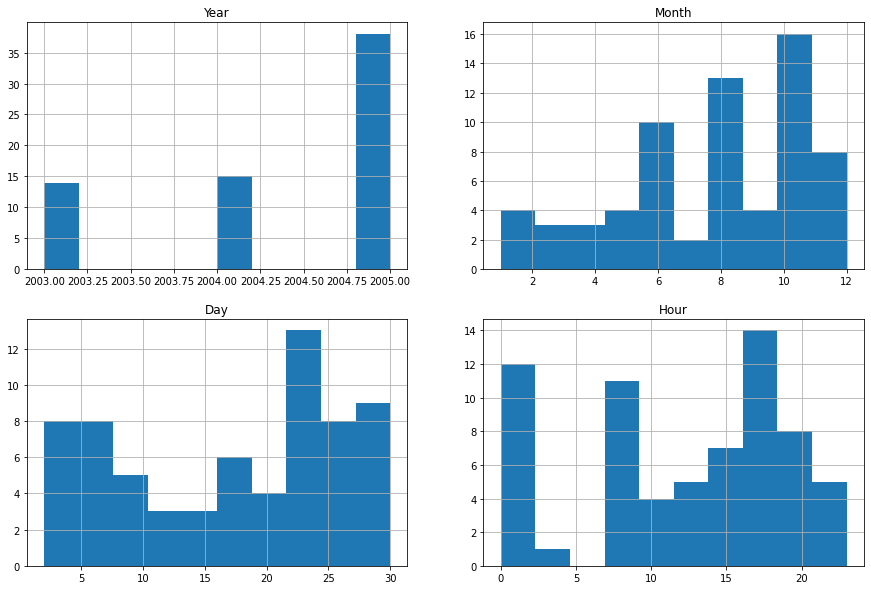

In [31]:
plt.figure(figsize=(15,10))

rows=2
cols=2

plt.subplot(rows,cols,1)
year_o.hist()
plt.title('Year')

plt.subplot(rows,cols,2)
month_o.hist()
plt.title('Month')

plt.subplot(rows,cols,3)
day_o.hist()
plt.title('Day')

plt.subplot(rows,cols,4)
hour_o.hist()
plt.title('Hour')